## Predicting whether a person has diabetes based on certain health metrics.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from datetime import datetime

In [2]:
def g(z):
    return 1 / (1 + np.exp(-z))

def f_x(a_out):
    return g(a_out)

def dense(a_in, W,b):
    units = W.shape[1]
    a_out = np.zeros(units)
    for j in range(units):
        w = W[:,j]
        z = np.dot(w,a_in) + b[j]
        a_out[j] = g(z)
    return a_out

def forward_pass(x, W1, b1, W2, b2, W3, b3, W4, b4):
    a1 = dense(x, W1, b1)
    a2 = dense(a1, W2, b2)
    a3 = dense(a2, W3, b3)
    a4 = dense(a3, W4, b4)
    return a1, a2, a3, a4

def binary_cross_entropy(y_true, y_pred):
    return - (y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

def backward_pass(x, y, a1, a2, a3, a4, W1, b1, W2, b2, W3, b3, W4, b4, learning_rate):
    # Gradients of loss with respect to output
    dL_da4 = a4 - y
    
    # Layer 4 gradients
    da4_dz4 = a4 * (1 - a4)
    dz4_dW4 = np.outer(a3, dL_da4 * da4_dz4)
    dz4_db4 = dL_da4 * da4_dz4
    
    # Update parameters for layer 4
    W4 -= learning_rate * dz4_dW4
    b4 -= learning_rate * dz4_db4

    # Layer 3 gradients
    dL_da3 = np.dot(W4, dL_da4 * da4_dz4)
    da3_dz3 = a3 * (1 - a3)
    dz3_dW3 = np.outer(a2, dL_da3 * da3_dz3)
    dz3_db3 = dL_da3 * da3_dz3

    # Update parameters for layer 3
    W3 -= learning_rate * dz3_dW3
    b3 -= learning_rate * dz3_db3

    # Layer 2 gradients
    dL_da2 = np.dot(W3, dL_da3 * da3_dz3)
    da2_dz2 = a2 * (1 - a2)
    dz2_dW2 = np.outer(a1, dL_da2 * da2_dz2)
    dz2_db2 = dL_da2 * da2_dz2

    # Update parameters for layer 2
    W2 -= learning_rate * dz2_dW2
    b2 -= learning_rate * dz2_db2

    # Layer 1 gradients
    dL_da1 = np.dot(W2, dL_da2 * da2_dz2)
    da1_dz1 = a1 * (1 - a1)
    dz1_dW1 = np.outer(x, dL_da1 * da1_dz1)
    dz1_db1 = dL_da1 * da1_dz1

    # Update parameters for layer 1
    W1 -= learning_rate * dz1_dW1
    b1 -= learning_rate * dz1_db1

    return W1, b1, W2, b2, W3, b3, W4, b4

### Creating the dataset

In [3]:
# Load the dataset
# url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
# columns = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI',
#            'DiabetesPedigreeFunction', 'Age', 'Outcome']
# data = pd.read_csv(url, header=None, names=columns)

# # Split the data into features and labels
# X = data.drop('Outcome', axis=1)
# y = data[['Outcome']]

# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [4]:
#Store the dataset
# X_train.reset_index(inplace=True,drop=True)
# X_test.reset_index(inplace=True,drop=True)
# y_train.reset_index(inplace=True,drop=True)
# y_test.reset_index(inplace=True,drop=True)

# date = datetime.now().strftime('%Y-%m-%d')

# X_train.to_csv(f'training_feat_{date}.csv', index=False)
# X_test.to_csv(f'testing_feat_{date}.csv', index=False)
# y_train.to_csv(f'training_label_{date}.csv', index=False)
# y_test.to_csv(f'testing_label_{date}.csv', index=False)

### Reading the data

In [5]:
# date = datetime.now().strftime('%Y-%m-%d')
date ='2024-'
X_train = pd.read_csv(f'training_feat_{date}.csv', index_col=False)
X_test = pd.read_csv(f'testing_feat_{date}.csv', index_col=False)
y_train = pd.read_csv(f'training_label_{date}.csv', index_col=False)
y_test = pd.read_csv(f'testing_label_{date}.csv', index_col=False)

X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

In [6]:
X_train.shape

(614, 8)

In [7]:
# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Initialize weights and biases for the network layers
input_dim = X_train.shape[1]
hidden_units1 = 16
hidden_units2 = 16
hidden_units3 = 8
output_units = 1

W1 = np.random.randn(input_dim, hidden_units1) * 0.01
b1 = np.zeros(hidden_units1)
W2 = np.random.randn(hidden_units1, hidden_units2) * 0.01
b2 = np.zeros(hidden_units2)
W3 = np.random.randn(hidden_units2, hidden_units3) * 0.01
b3 = np.zeros(hidden_units3)
W4 = np.random.randn(hidden_units3, output_units) * 0.01
b4 = np.zeros(output_units)

# Learning rate and epochs
learning_rate = 0.08
epochs = 800

C:\Users\SiddharthMishra\AppData\Local\Temp\ipykernel_2364\334517311.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
Training: 100%|██████████████████████████████████████████████████████████████████████| 800/800 [01:40<00:00,  7.96it/s]


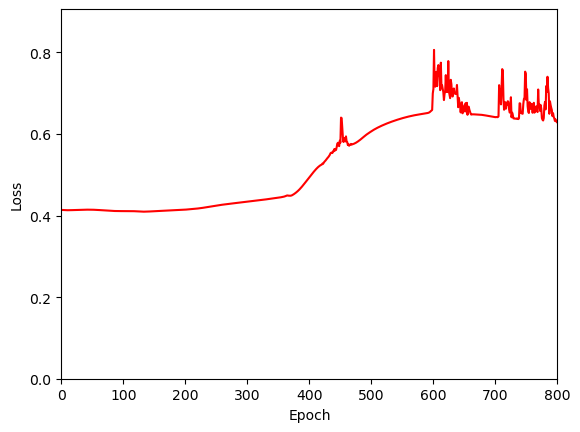

In [9]:
# Initialize the plot
plt.ion()
fig, ax = plt.subplots()
line, = ax.plot([], [], 'r-')
ax.set_xlim(0, epochs)
ax.set_ylim(0, 1)
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
fig.show()

losses = []

for epoch in tqdm(range(epochs), desc='Training'):
    total_loss = 0
    for i in range(X_train.shape[0]):
        x = X_train[i]
        y = y_train[i]
        
        # Forward pass
        a1, a2, a3, a4 = forward_pass(x, W1, b1, W2, b2, W3, b3, W4, b4)
        y_pred = a4
        
        # Calculate loss
        loss = binary_cross_entropy(y, y_pred)
        total_loss += loss
        
        # Backward pass and parameter update
        W1, b1, W2, b2, W3, b3, W4, b4 = backward_pass(
            x, y, a1, a2, a3, a4, W1, b1, W2, b2, W3, b3, W4, b4, learning_rate)
    
    avg_loss = total_loss / X_train.shape[0]
    losses.append(avg_loss)
    
    # Update the plot
    line.set_xdata(np.arange(epoch + 1))
    line.set_ydata(losses)
    ax.set_ylim(0, max(losses) + 0.1)
    fig.canvas.draw()
    fig.canvas.flush_events()
